# Modelo preentrenado sin aumeto de datos

Partiremos de un modelo preentrenado para clasificar gatos y perros de la API de Google. Primero sin aumento de datos,

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob


In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

In [ ]:
# Vemos el directorio en el que se ha almacenado el zip descargado
print(path_to_zip)

/root/.keras/datasets/cats_and_dogs.zip


In [ ]:
# Vemos que contiene la carpeta descargada
print(os.listdir(os.path.dirname(path_to_zip)))

['cats_and_dogs_filtered.zip', 'cats_and_dogs.zip', 'cats_and_dogs_filtered']


In [ ]:
# Creamos el enlace al directorio donde se encuentran las imágenes y vemos qué contiene
path_images1 = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(os.listdir(path_images))

['train', 'vectorize.py', 'validation']


In [ ]:
# Creamos enlaces a los directorios con las imágenes de entrenamiento y validación
path_train = os.path.join(path_images, 'train')
path_validation = os.path.join(path_images, 'validation')

In [ ]:
# Vemos cómo están organizados los directorios
print(os.listdir(path_validation))

['dogs', 'cats']


In [ ]:
# Vamos a emplear el método image_dataset_from_directory de tensorflow para crear los datasets

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(path_train,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_and_test_dataset = image_dataset_from_directory(path_validation,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# No es un Pandas Dataframe
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_dataset.class_names

['cats', 'dogs']

In [ ]:
# Guardamos parte del conjunto de datos de validación para el test externo

val_batches = tf.data.experimental.cardinality(validation_and_test_dataset) # Devuleve el nº de batches: 32. Por casualidad coincide con el tamaño de batch
# tf.data.experimental.cardinality(train_dataset)
print('Número de lotes de validación: ', val_batches.numpy())
test_dataset = validation_and_test_dataset.take(val_batches // 5)
validation_dataset = validation_and_test_dataset.skip(val_batches // 5)

Número de lotes de validación:  32


In [ ]:
print('Número de lotes de validación: ', tf.data.experimental.cardinality(validation_dataset).numpy())
print('Número de lotes de test: ', tf.data.experimental.cardinality(test_dataset).numpy())

Número de lotes de validación:  26
Número de lotes de test:  6


El siguiente bloque de código se añade por defecto cuando queramos leer imágenes del sistema de archivos de manera dinámica para evitar que la E/S se bloquee. Permite mejorar el rendimiento en la carga de datos.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
mobilenet_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
mobilenet_model.trainable = False

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
def create_cnn_tc():

    input = Input(shape=(160, 160, 3))
    # Capa preprocesado
    x = preprocess_input(input)
    # Añadimos modelo base
    x = mobilenet_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Clasificación binaria
    output = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=[input], outputs=[output])

    return model

model_tc = create_cnn_tc()
model_tc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [ ]:
model_tc.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_tc = model_tc.fit(train_dataset,
                          epochs=10,
                          validation_data=validation_dataset,
                          verbose=1)

Epoch 1/10
63/63 [==============================] - 12s 88ms/step - loss: 0.3456 - accuracy: 0.8525 - val_loss: 0.1222 - val_accuracy: 0.9666
Epoch 2/10
63/63 [==============================] - 3s 52ms/step - loss: 0.0938 - accuracy: 0.9725 - val_loss: 0.0931 - val_accuracy: 0.9728
Epoch 3/10
63/63 [==============================] - 4s 52ms/step - loss: 0.0660 - accuracy: 0.9805 - val_loss: 0.0677 - val_accuracy: 0.9802
Epoch 4/10
63/63 [==============================] - 3s 51ms/step - loss: 0.0533 - accuracy: 0.9830 - val_loss: 0.0676 - val_accuracy: 0.9777
Epoch 5/10
63/63 [==============================] - 4s 53ms/step - loss: 0.0428 - accuracy: 0.9880 - val_loss: 0.0612 - val_accuracy: 0.9790
Epoch 6/10
63/63 [==============================] - 4s 61ms/step - loss: 0.0373 - accuracy: 0.9900 - val_loss: 0.0546 - val_accuracy: 0.9839
Epoch 7/10
63/63 [==============================] - 3s 51ms/step - loss: 0.0321 - accuracy: 0.9940 - val_loss: 0.0522 - val_accuracy: 0.9827
Epoch 8/10
6

In [ ]:
def plot_history(history):
    plt.figure(figsize = (10,10))
    plt.plot(history['accuracy'], label="Entrenamiento")
    plt.plot(history['val_accuracy'], label="Validación")
    plt.ylabel('Exactitud')
    plt.xlabel('Época')
    plt.ylim([0,1])
    plt.legend(loc="lower right")

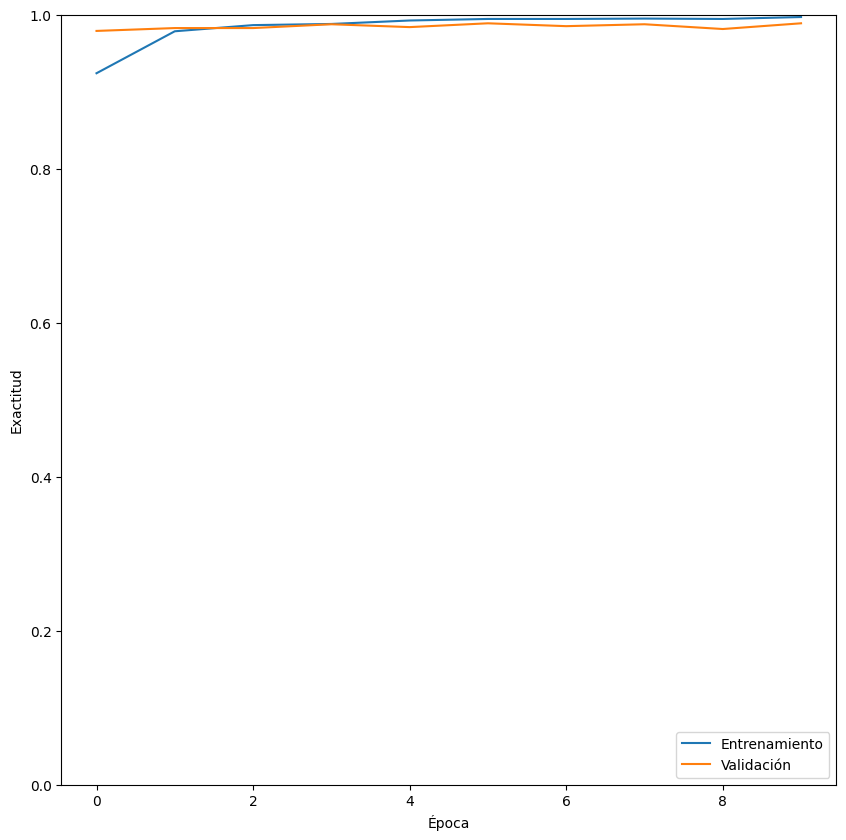

In [ ]:
plot_history(history_tc.history)

In [ ]:
_, accuracy_tc = model_tc.evaluate(test_dataset, verbose=0)
print('Exactitud test transferencia conocimiento :', accuracy_tc)

Exactitud test transferencia conocimiento : 0.9791666865348816


# Modelo preentrenado con aumento de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Directorios de las imágenes de entrenamiento y validación
train_dir = '/content/drive/MyDrive/Colab Notebooks/sistemas IA/cats_and_dogs_filtered/train'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/sistemas IA/cats_and_dogs_filtered/validation'

# Listar archivos en la carpeta de entrenamiento
train_files = os.listdir(train_dir)
print("Archivos de entrenamiento:", len(train_files))

# Listar archivos en la carpeta de validación
validation_files = os.listdir(validation_dir)
print("Archivos de validación:", len(validation_files))


Archivos de entrenamiento: 2
Archivos de validación: 2


**PREGUNTA**

1. Crea ImageDataGenerator con rango de rotaticón 20, zoom 0.5, de desplazamiento en anchura 0.2, desplazamiento en altura 0.2, rango de recorte (shear) 0.15, espejo horizontal y fill_mode "nearest"

In [ ]:
tam_imagen = (160, 160)

# Crear un generador de datos de imágenes con las transformaciones especificadas
datagen = ImageDataGenerator(
    rotation_range=20,  # Rango de rotación en grados
    zoom_range=0.5,  # Rango de zoom aleatorio
    width_shift_range=0.2,  # Rango de desplazamiento horizontal
    height_shift_range=0.2,  # Rango de desplazamiento vertical
    shear_range=0.15,  # Rango de recorte (shear)
    horizontal_flip=True,  # Espejo horizontal
    fill_mode='nearest'  # Modo de relleno
)

**PREGUNTA**


2. Crea un generador de imágenes de entrenamiento y otro de validación a partir del ImageDataGenerator anterior con flow_from_directory


In [ ]:

# Crear generador de imágenes de entrenamiento
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=tam_imagen,
    batch_size=32,
    class_mode='binary',       # Modo de clasificación: binario (gatos=0, perros=1)
    shuffle=True                # Mezclar las imágenes aleatoriamente
)

# Crear generador de imágenes de validación
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=tam_imagen,
    batch_size=32,
    class_mode='binary',       # Modo de clasificación: binario (gatos=0, perros=1)
    shuffle=False               # No es necesario mezclar las imágenes para validación
)

# Verificar las clases asignadas a cada índice
print("Clases en el generador de entrenamiento:", train_generator.class_indices)
print("Clases en el generador de validación:", validation_generator.class_indices)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Clases en el generador de entrenamiento: {'cats': 0, 'dogs': 1}
Clases en el generador de validación: {'cats': 0, 'dogs': 1}


**PREGUNTA**

3. Utiliízalos con el modelo mobile_net anterior y plotea y comprueba el accuracy

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
mobilenet_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
def create_cnn_tc():

    input = Input(shape=(160, 160, 3))
    # Capa preprocesado
    x = preprocess_input(input)
    # Añadimos modelo base
    x = mobilenet_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Clasificación binaria
    output = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=[input], outputs=[output])

    return model

model_aug = create_cnn_tc()
model_aug.summary()
model_aug.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_tc = model_aug.fit(train_generator,
                          epochs=10,
                          validation_data=validation_generator,
                          verbose=1)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_5 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [ ]:
def plot_history(history):
    plt.figure(figsize = (10,10))
    plt.plot(history['accuracy'], label="Entrenamiento")
    plt.plot(history['val_accuracy'], label="Validación")
    plt.ylabel('Exactitud')
    plt.xlabel('Época')
    plt.ylim([0,1])
    plt.legend(loc="lower right")

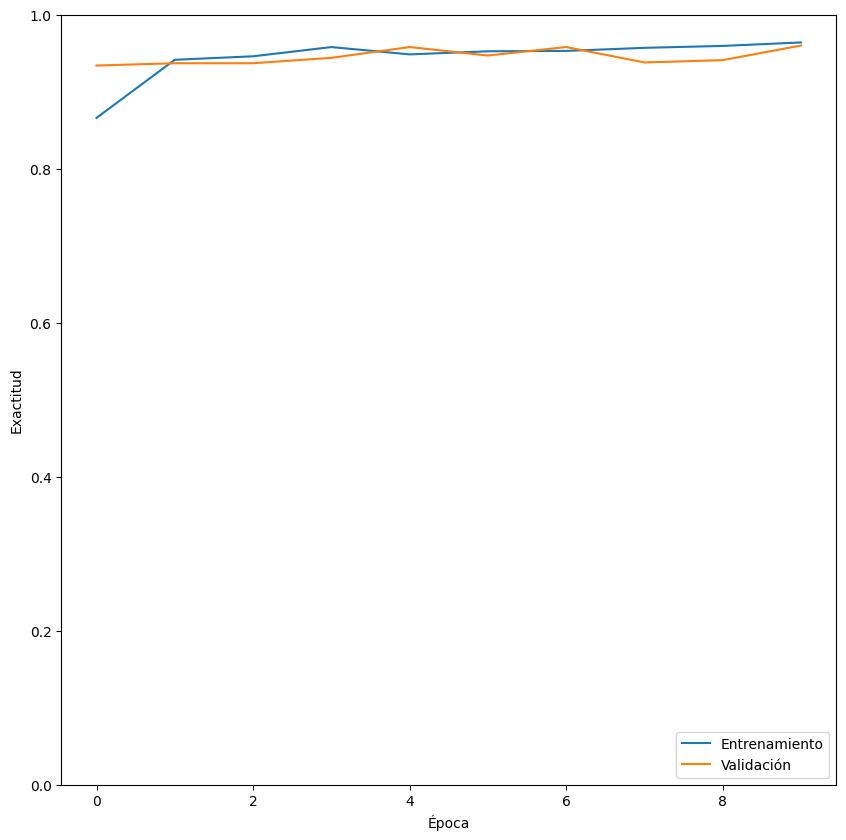

In [ ]:
plot_history(history_tc.history)

In [ ]:

loss_test, accuracy_test = model_aug.evaluate(validation_generator, verbose = 0)
print(f'Exactitud en el conjunto de prueba: {accuracy_test:.4f}')

Exactitud en el conjunto de prueba: 0.9570


In [ ]:
_, accuracy_aug = model_aug.evaluate(test_dataset, verbose=0)
print('Exactitud test transferencia conocimiento :', accuracy_aug)

Exactitud test transferencia conocimiento : 0.9739583134651184
